In [1]:
# Standard libraries
import numpy as np
import qutip as qt

# for plotting 2D and 3D plots
from matplotlib import cm, colors
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

# scipy maximization functions
import scipy.constants 
from scipy.linalg import expm, sinm, cosm
import scipy.fftpack as sfft 

# for making GIFs
import imageio

# for increasing the writing screen size in jupyter
from IPython.display import clear_output

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

# Defining the states of the three level NV

qt.basis(3,0) = $\left|0\right>$ ,
qt.basis(3,1) = $\left|1\right>$ ,
qt.basis(3,2) = $\left|e\right>$ .

In [2]:
state0 = qt.basis(3,0)
state1 = qt.basis(3,1)
statee = qt.basis(3,2)

# Declaring Initial state and number of NVs

Default case is for two spins with initial state as follows

$\left|NV_1\right> = \frac{\left|0\right>+\left|1\right>}{2}$, $\left|NV_2\right> = \left|0\right>$

#### Pin = Initial density matrix,

#### Pinmc = Initial state (defined for Monte Carlo simulation)

In [257]:
n_spins = 2
nv1 = (qt.basis(3,1) + qt.basis(3,0))/(np.sqrt(2))
nv2 = qt.basis(3,0)
# nv3 = (1/np.sqrt(2))*(qt.basis(3,0)+qt.basis(3,1))
Pin = qt.tensor(qt.ket2dm(nv1),qt.ket2dm(nv2))#,qt.ket2dm(nv3))
Pinmc = qt.tensor(nv1,nv2)

# Parameters

g is an array (size = n_spins) of coupling constant for each NV to cavity coupling

Dl is the detuning for the laser-NV interaction

Om is the rabu frequency of laser

Th is the effective NV-NV coupling (after applying the adiabatic elimination). 

kp is the cavity decay rate

$\gamma_{e0}$ = The spontaneous emmision from $\left|e\right>$ to $\left|0\right>$

$\gamma_{e1}$ = The spontaneous emmision from $\left|e\right>$ to $\left|1\right>$

$\gamma_{10}$ = The spontaneous emmision from $\left|1\right>$ to $\left|0\right>$


In [258]:
# Coupling between NVs
g = np.full(n_spins,1)


# Detuning of Laser frequency
Dl = 10*np.mean(g)


# Rabi Frequency of Laser
Om = 0.01*g


# Effective NV-NV Coupling
Th = np.zeros((n_spins,n_spins))
for i in range(n_spins):
    Th[i] = g[i]*g/Dl


# Effective spin-spin Coupling
xi = np.mean(Om)*np.mean(Om)/np.mean(Th)


# Decay terms
kp = 0
ye0 = 0.0001
y10 = ye0/5
ye1 = ye0

# Declaring Hamlitonian, Collapse Operators, Measurement Operators for "n" NVs

## Hamiltonian
The total hamiltonian consists of two parts. The self energy and the interaction energy. 

$$H_{self} = \sum_{i}^{n_{spin}} \Omega_i \left|e\right>_i\left<1\right|$$

$$H_{cross} = \sum_{i}^{n_{spin}}\sum_{j}^{n_{spin}} \Theta_{i,j}\left|e\right>_i\left<0\right|\otimes \left|0\right>_j\left<e\right| $$

## Collapse Operators
The collapse operator takes into consideration the spontaneous emission from all the three levels. They are defined as follows

$$ c^{(1)}_{ops} = \sum_i^{n_{spins}}\gamma_{10}\left[2\sigma^i_{01}\rho\sigma^i_{10} - \left\{\sigma^i_{10}\sigma^i_{01},\rho\right\}\right]$$

$$ c^{(2)}_{ops} = \sum_i^{n_{spins}}\sum_{j = (1,2)}\gamma_{ej}\left[2\sigma^i_{je}\rho\sigma^i_{ej} - \left\{\sigma^i_{ej}\sigma^i_{je},\rho\right\}\right]$$

## Measurement Operators
The pauli operator for a given two level system within a three level system. 

### Type 1

$$\sigma_x = \left(\begin{array}{*{11}c}0.0 & 1.0 & 0.0\\1.0 & 0.0 & 0.0\\0.0 & 0.0 & 0.0\\\end{array}\right)$$

$$\sigma_y = \left(\begin{array}{*{11}c}0.0 & -1.0j & 0.0\\1.0j & 0.0 & 0.0\\0.0 & 0.0 & 0.0\\\end{array}\right)$$

$$\sigma_z = \left(\begin{array}{*{11}c}1.0 & 0.0 & 0.0\\0.0 & -1.0 & 0.0\\0.0 & 0.0 & 0.0\\\end{array}\right)$$

The above are what the code is set to. There is a major **confusion** on what the pauli operators should be. The other possibility is fo have the following

### Type 2

$$\sigma_x = \left(\begin{array}{*{11}c}0.0 & 1.0 & 0.0\\1.0 & 0.0 & 0.0\\0.0 & 0.0 & 1.0\\\end{array}\right)$$

$$\sigma_y = \left(\begin{array}{*{11}c}0.0 & -1.0j & 0.0\\1.0j & 0.0 & 0.0\\0.0 & 0.0 & 1.0\\\end{array}\right)$$

$$\sigma_z = \left(\begin{array}{*{11}c}1.0 & 0.0 & 0.0\\0.0 & -1.0 & 0.0\\0.0 & 0.0 & 1.0\\\end{array}\right)$$



In [264]:
null = 0*qt.qeye(3)
for i in range(n_spins-1):
    null = qt.tensor(null,0*qt.qeye(3))

Iter = np.identity(n_spins)

# Individual NV Hamiltonian
Hself = null
for i in range(n_spins):
    temp = Iter[i,0]*Om[0]*statee*(state1.dag()) + (1-Iter[i,0])*qt.qeye(3)
    for j in range(1,n_spins):
        temp = qt.tensor(temp,Iter[i,j]*Om[j]*statee*(state1.dag()) \
                         + (1-Iter[i,j])*qt.qeye(3))
    Hself = Hself + temp

# Interaction (NV-NV) Hamiltonian
Hcross = null
for i in range(n_spins):
    for j in range(i+1,n_spins):
        temp = qt.qeye(1)
        for k in range(i):
            temp = qt.tensor(temp,qt.qeye(3))
        temp = qt.tensor(temp,statee*(state0.dag()))
        for l in range(j-i-1):
             temp = qt.tensor(temp,qt.qeye(3))
        temp = qt.tensor(temp,state0*(statee.dag()))
        for m in range(n_spins-j-1):
            temp = qt.tensor(temp,qt.qeye(3))
        temp = Th[i,j]*temp.ptrace(np.linspace(1,n_spins,n_spins,dtype = int))
        Hcross = Hcross + temp
        
H = Hself + Hcross
Heff = H + H.dag()

# Collapse Operator
c_ops = []
# for 1 -> 0 Spontaneous emission
for i in range(n_spins):
    temp = Iter[i,0]*np.sqrt(y10)*state0*(state1.dag()) + (1-Iter[i,0])*qt.qeye(3)
    for j in range(1,n_spins):
        temp = qt.tensor(temp,Iter[i,j]*np.sqrt(y10)*state0*(state1.dag()) \
                         + (1-Iter[i,j])*qt.qeye(3))
    c_ops.append(temp)

# for e -> 0 Spontaneous emission
for i in range(n_spins):
    temp = Iter[i,0]*np.sqrt(ye0)*state0*(statee.dag()) + (1-Iter[i,0])*qt.qeye(3)
    for j in range(1,n_spins):
        temp = qt.tensor(temp,Iter[i,j]*np.sqrt(ye0)*state0*(statee.dag()) \
                         + (1-Iter[i,j])*qt.qeye(3))
    c_ops.append(temp)
    
# for e -> 1 Spontaneous emission
for i in range(n_spins):
    temp = Iter[i,0]*np.sqrt(ye1)*state1*(statee.dag()) + (1-Iter[i,0])*qt.qeye(3)
    for j in range(1,n_spins):
        temp = qt.tensor(temp,Iter[i,j]*np.sqrt(ye1)*state1*(statee.dag()) \
                         + (1-Iter[i,j])*qt.qeye(3))
    c_ops.append(temp)

# Defining the Pauli Operators for a single NV
sigmax =  state0*(state1.dag()) + state1*(state0.dag())
sigmay =  - 1j*state0*(state1.dag()) + 1j*state1*(state0.dag())
sigmaz =  state0*(state0.dag()) - state1*(state1.dag())

# sigmax =  statee*(statee.dag()) + state0*(state1.dag()) + state1*(state0.dag())
# sigmay =  statee*(statee.dag()) - 1j*state0*(state1.dag()) + 1j*state1*(state0.dag())
# sigmaz =  statee*(statee.dag()) + state0*(state0.dag()) - state1*(state1.dag())

# Defining all angular momentum operators till second power

Jx = null
for i in range(n_spins):
    temp = Iter[i,0]*sigmax/2 + (1-Iter[i,0])*qt.qeye(3)
    for j in range(1,n_spins):
        temp = qt.tensor(temp,Iter[i,j]*sigmax/2 + (1-Iter[i,j])*qt.qeye(3))
    Jx = Jx + temp
    
Jy = null
for i in range(n_spins):
    temp = Iter[i,0]*sigmay/2 + (1-Iter[i,0])*qt.qeye(3)
    for j in range(1,n_spins):
        temp = qt.tensor(temp,Iter[i,j]*sigmay/2 + (1-Iter[i,j])*qt.qeye(3))
    Jy = Jy + temp
    
Jz = null
for i in range(n_spins):
    temp = Iter[i,0]*sigmaz/2 + (1-Iter[i,0])*qt.qeye(3)
    for j in range(1,n_spins):
        temp = qt.tensor(temp,Iter[i,j]*sigmaz/2 + (1-Iter[i,j])*qt.qeye(3))
    Jz = Jz + temp
    
Jxx = Jx*Jx
Jyy = Jy*Jy
Jzz = Jz*Jz
Jxy = Jx*Jy
Jyx = Jy*Jx
Jyz = Jy*Jz
Jzy = Jz*Jy
Jzx = Jz*Jx
Jxz = Jx*Jz
pop1 = qt.tensor(state1*(state1.dag()),state0*(state0.dag()))
pop2 = qt.tensor(state0*(state0.dag()),state1*(state1.dag()))
meas = [pop1,pop2,Jx,Jy,Jz,Jxx,Jyy,Jzz,Jxy,Jyx,Jyz,Jzy,Jzx,Jxz]

# Time Variable & Measurement Operator

Time is varied from 0 to $\frac{\pi}{2\xi}$ where xi is the effective coupling of the NV-NV interaction as defined in the paper

In [265]:
t_dense = 100
t = np.linspace(0,np.pi/(2*xi),t_dense)

# Lindbladian Master Equation => Simulation

In [266]:
result = qt.mesolve(Heff,Pin,t,c_ops,meas,options=qt.Options(nsteps=200000))
epop1,epop2,eJx,eJy,eJz,eJxx,eJyy,eJzz,eJxy,eJyx,eJyz,eJzy,eJzx,eJxz = result.expect

# Measuring Wineland Parameter

$$\xi^2_R = \frac{N(\Delta J^{min}_{\vec{n}_{\perp}})^2}{\left|\left<\vec{J}\right>\right|^2}$$

Here $j = N/2$ and the formula for the minimization of the variance of the Angular momenum is as follows

$$\lambda = \frac{1}{2}\left[\left<J^2_{n_1}+J^2_{n_2}\right> -\sqrt{\left<J^2_{n_1} - J^2_{n_2}\right>+ 4\text{Cov}\left(J_{n_1},J_{n_{2}}\right)} \right]$$

In [267]:
meanJ = np.array([eJx,eJy,eJz])
meanJval = np.linalg.norm(meanJ,axis=0)
meanJ = np.divide(meanJ,np.linalg.norm(meanJ,axis=0))

theta = np.arccos(meanJ[2,:])
phi = theta*0
for i in range(t_dense):
    if eJy[i] > 0 and theta[i] != 0.0:
        phi[i] = np.arccos(np.around(meanJ[0,i]/np.sin(theta[i]),decimals=15))
    elif theta[i] != 0 :
        phi[i] = 2*np.pi - np.arccos(np.around(meanJ[0,i]/np.sin(theta[i]),decimals=15))

n1 = np.array([-np.sin(phi),np.cos(phi),0*np.cos(phi)])
n2 = np.array([np.cos(theta)*np.cos(phi),np.cos(theta)*np.sin(phi),-np.sin(theta)])

squeeze = np.zeros(t_dense)
for i in range(t_dense):
    J2n1 = n1[0,i]**2*eJxx[i] + n1[1,i]**2*eJyy[i] + n1[2,i]**2*eJzz[i] \
         + n1[0,i]*n1[1,i]*(eJxy[i] + eJyx[i]) + n1[1,i]*n1[2,i]*(eJyz[i] + eJzy[i]) \
         + n1[0,i]*n1[2,i]*(eJxz[i] + eJzx[i])
    J2n2 = n2[0,i]**2*eJxx[i] + n2[1,i]**2*eJyy[i] + n2[2,i]**2*eJzz[i] \
         + n2[0,i]*n2[1,i]*(eJxy[i] + eJyx[i]) + n2[1,i]*n2[2,i]*(eJyz[i] + eJzy[i]) \
         + n2[0,i]*n2[2,i]*(eJxz[i] + eJzx[i])
    Jn1Jn2 = n1[0,i]*(n2[0,i]*eJxx[i] + n2[1,i]*eJxy[i] + n2[2,i]*eJxz[i]) \
           + n1[1,i]*(n2[0,i]*eJyx[i] + n2[1,i]*eJyy[i] + n2[2,i]*eJyz[i]) \
           + n1[2,i]*(n2[0,i]*eJzx[i] + n2[1,i]*eJzy[i] + n2[2,i]*eJzz[i])
    Jn2Jn1 = n2[0,i]*(n1[0,i]*eJxx[i] + n1[1,i]*eJxy[i] + n1[2,i]*eJxz[i]) \
           + n2[1,i]*(n1[0,i]*eJyx[i] + n1[1,i]*eJyy[i] + n1[2,i]*eJyz[i]) \
           + n2[2,i]*(n1[0,i]*eJzx[i] + n1[1,i]*eJzy[i] + n1[2,i]*eJzz[i])
    a = np.real(J2n1 + J2n2)
    b = np.real(J2n1 - J2n2)
    c = np.real(0.5*(Jn1Jn2 + Jn2Jn1))
    squeeze[i] = (n_spins)/2*(a - np.sqrt(b**2 + 4*c**2))/(meanJval[i]**2)

## Initial Condition 1
### For Pauli Operators of Type 1

With Initial conditions 

$\left|NV_1\right> = \frac{\left|0\right>+\left|1\right>}{2}$, $\left|NV_2\right> = \left|0\right>$

Minimum Squeezing = 
1.0000000000000002


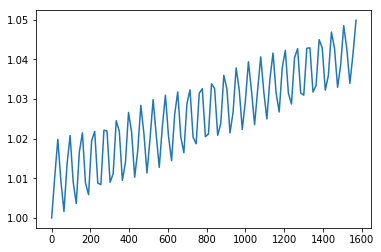

In [268]:
plt.plot(t,squeeze)
print("Minimum Squeezing = ")
print(np.amin(squeeze))

## Initial Condition 1
### For Pauli Operators of Type 2
With Initial conditions 

$\left|NV_1\right> = \frac{\left|0\right>+\left|1\right>}{2}$, $\left|NV_2\right> = \left|0\right>$

Minimum Squeezing = 
0.9797424825171978


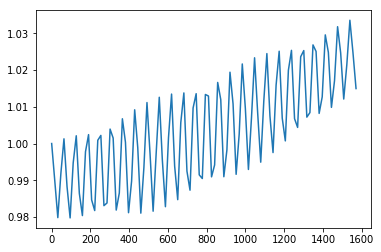

In [263]:
plt.plot(t,squeeze)
print("Minimum Squeezing = ")
print(np.amin(squeeze))

## Initial Condition 1
### Population Transfer as shown in the paper

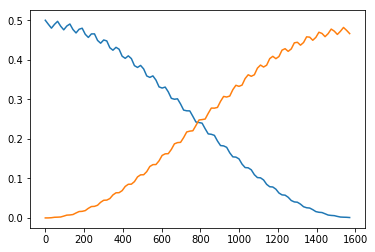

In [229]:
plt.plot(t,epop1)
plt.plot(t,epop2)

## Initial Condition 2
### For Pauli Operators of Type 1

With Initial conditions 

$\left|NV_1\right> = \frac{\left|0\right>+\left|1\right>}{2}$, $\left|NV_2\right> = \left|1\right>$

Minimum Squeezing = 
1.0000000000000002


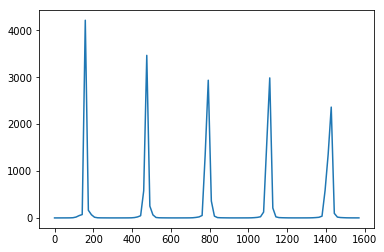

In [250]:
plt.plot(t,squeeze)
print("Minimum Squeezing = ")
print(np.amin(squeeze))

## Initial Condition 2
### For Pauli Operators of Type 2
With Initial conditions 

$\left|NV_1\right> = \frac{\left|0\right>+\left|1\right>}{2}$, $\left|NV_2\right> = \left|1\right>$

Minimum Squeezing = 
0.24093245504318714


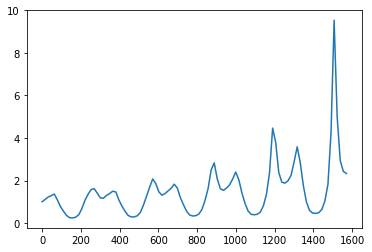

In [255]:
plt.plot(t,squeeze)
print("Minimum Squeezing = ")
print(np.amin(squeeze))

## Initial Condition 2
### Population Transfer as shown in the paper

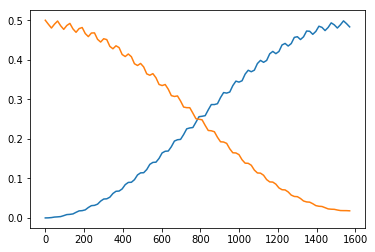

In [256]:
plt.plot(t,epop1)
plt.plot(t,epop2)